## Setup

In [1]:
import torchvision
import torch
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from dcai.score import ScoreTracker
from dcai.dataset import TrainDataset, ValidationDataset
from typing import List

In [2]:
# Start a score tracker to track score as function of the number of annotations bought
score_tracker = ScoreTracker(team_name="marcel-brute-force")

# Get a MNIST train data set
train_dataset = TrainDataset()

## Example of buying an annotation

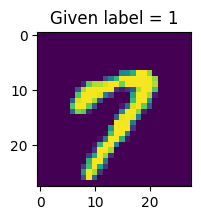

In [3]:
plt.figure(figsize=(2,2))
plt.title(f"Given label = {train_dataset[15][1]}")
plt.imshow(train_dataset[15][0]);

In [4]:
# Buy an annotation
train_dataset.buy_annotation(15)

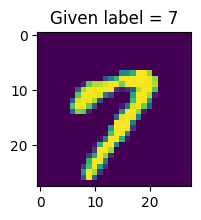

In [5]:
plt.figure(figsize=(2,2))
plt.title(f"Given label = {train_dataset[15][1]}")
plt.imshow(train_dataset[15][0]);

In [6]:
for x in [1,2,7]:
    print(f"Num examples for given class {x}: {np.sum(train_dataset.y == x)}")
    # np.sum(train_dataset.y == 1)

Num examples for given class 1: 13006
Num examples for given class 2: 5958
Num examples for given class 7: 1


## Train with the current data set and get the score

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/marcelraas/PycharmProjects/data-centric-hackathon/venv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:67: UserWarning: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
  warning_cache.warn(


┏━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name        ┃ Type                      ┃ Params ┃
┡━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ model       │ SimpleMnistModel          │  1.2 M │
│ 1 │ conf_matrix │ MulticlassConfusionMatrix │      0 │
│ 2 │ precision   │ MulticlassPrecision       │      0 │
│ 3 │ recall      │ MulticlassRecall          │      0 │
└───┴─────────────┴───────────────────────────┴────────┘

Trainable params: 1.2 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 1.2 M                                                                                                
Total estimated model params size (MB): 4

Output()

/Users/marcelraas/PycharmProjects/data-centric-hackathon/venv/lib/python3.10/site-packages/pytorch_lightning/traine
r/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers
which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number
of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(

/Users/marcelraas/PycharmProjects/data-centric-hackathon/venv/lib/python3.10/site-packages/torchmetrics/functional/
classification/stat_scores.py:416: UserWarning: MPS: no support for int64 reduction ops, casting it to int32 
(Triggered internally at 
/Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/mps/operations/ReduceOps.mm:144.)
  fp = confmat.sum(0) - tp

/Users/marcelraas/PycharmProjects/data-centric-hackathon/venv/lib/python3.10/site-packages/pytorch_lightning/traine
r/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many 
workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is 
the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(

`Trainer.fit` stopped: `max_epochs=1` reached.


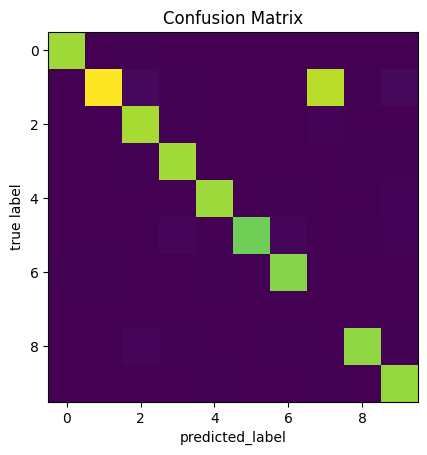

In [7]:
model = score_tracker.train_and_score_model(train_dataset, plot_confusion_matrix=True)

In [8]:
print(model)

LitSimpleMnist(
  (model): SimpleMnistModel(
    (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
    (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (dropout1): Dropout(p=0.25, inplace=False)
    (dropout2): Dropout(p=0.5, inplace=False)
    (fc1): Linear(in_features=9216, out_features=128, bias=True)
    (fc2): Linear(in_features=128, out_features=10, bias=True)
  )
  (conf_matrix): MulticlassConfusionMatrix()
  (precision): MulticlassPrecision()
  (recall): MulticlassRecall()
)


The score function returns the fitted model, so you can use this model for active learning etc. You don't have to use this model.

## What else can you do?

In [9]:
print(train_dataset.__doc__)

Your working train data set.

    This class loads MNIST data and maps the true label 7 to given label 1.

    You can buy an annotation using (this will cost you two annotations):
    ```
    train_dataset.buy_annotation([1, 2])
    ```
    Obviously, it does not make sense to buy annotations for data points that have a given label other than 1.
    You are responsible for not making this mistake.

    You can exclude a data point using:
    ```
    train_dataset.exclude_datapoints([4012, 2031])
    ```
    These data points will not be used when fitting the model in the ScoreTracker function. This is intended for:
     * excluding data points for which the labels could be wrong
     * class balancing

    ⚠️ IMPORTANT: the data points that you exclude are still part of the dataset. This means you can expect
    `train_dataset.x`, `train_dataset.y`, `len(train_dataset)`, etc. to be identical to the values before the operation.
    Only if you use the `train_dataset.subset_from_include

## Naive/baseline approach: Randomly annotate!

Your method should at least have a better performance than this :D

In [10]:
def iterate_in_batches(it: List, batch_size: int):
    i=0
    while True:
        ret = it[i:i+batch_size]
        if len(ret) == 0:
            return
        yield ret
        i += batch_size

In [11]:
labels = pd.Series(train_dataset.y)
labels_1 = labels[labels == 1]

# Excluding the given label class 1, we will only include data points that we have bought annotations for
train_dataset.exclude_datapoints(labels_1.index)

In [12]:
for batch in iterate_in_batches(labels_1, 2048):
    for el in batch.index:
        train_dataset.buy_annotation(el)
    train_dataset.include_datapoints(batch.index)
        
    score_tracker.train_and_score_model(train_dataset, plot_confusion_matrix=False)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


┏━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name        ┃ Type                      ┃ Params ┃
┡━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ model       │ SimpleMnistModel          │  1.2 M │
│ 1 │ conf_matrix │ MulticlassConfusionMatrix │      0 │
│ 2 │ precision   │ MulticlassPrecision       │      0 │
│ 3 │ recall      │ MulticlassRecall          │      0 │
└───┴─────────────┴───────────────────────────┴────────┘

Trainable params: 1.2 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 1.2 M                                                                                                
Total estimated model params size (MB): 4

Output()

`Trainer.fit` stopped: `max_epochs=1` reached.


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


┏━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name        ┃ Type                      ┃ Params ┃
┡━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ model       │ SimpleMnistModel          │  1.2 M │
│ 1 │ conf_matrix │ MulticlassConfusionMatrix │      0 │
│ 2 │ precision   │ MulticlassPrecision       │      0 │
│ 3 │ recall      │ MulticlassRecall          │      0 │
└───┴─────────────┴───────────────────────────┴────────┘

Trainable params: 1.2 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 1.2 M                                                                                                
Total estimated model params size (MB): 4

Output()

`Trainer.fit` stopped: `max_epochs=1` reached.


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


┏━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name        ┃ Type                      ┃ Params ┃
┡━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ model       │ SimpleMnistModel          │  1.2 M │
│ 1 │ conf_matrix │ MulticlassConfusionMatrix │      0 │
│ 2 │ precision   │ MulticlassPrecision       │      0 │
│ 3 │ recall      │ MulticlassRecall          │      0 │
└───┴─────────────┴───────────────────────────┴────────┘

Trainable params: 1.2 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 1.2 M                                                                                                
Total estimated model params size (MB): 4

Output()

`Trainer.fit` stopped: `max_epochs=1` reached.


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


┏━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name        ┃ Type                      ┃ Params ┃
┡━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ model       │ SimpleMnistModel          │  1.2 M │
│ 1 │ conf_matrix │ MulticlassConfusionMatrix │      0 │
│ 2 │ precision   │ MulticlassPrecision       │      0 │
│ 3 │ recall      │ MulticlassRecall          │      0 │
└───┴─────────────┴───────────────────────────┴────────┘

Trainable params: 1.2 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 1.2 M                                                                                                
Total estimated model params size (MB): 4

Output()

`Trainer.fit` stopped: `max_epochs=1` reached.


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


┏━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name        ┃ Type                      ┃ Params ┃
┡━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ model       │ SimpleMnistModel          │  1.2 M │
│ 1 │ conf_matrix │ MulticlassConfusionMatrix │      0 │
│ 2 │ precision   │ MulticlassPrecision       │      0 │
│ 3 │ recall      │ MulticlassRecall          │      0 │
└───┴─────────────┴───────────────────────────┴────────┘

Trainable params: 1.2 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 1.2 M                                                                                                
Total estimated model params size (MB): 4

Output()

`Trainer.fit` stopped: `max_epochs=1` reached.


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


┏━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name        ┃ Type                      ┃ Params ┃
┡━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ model       │ SimpleMnistModel          │  1.2 M │
│ 1 │ conf_matrix │ MulticlassConfusionMatrix │      0 │
│ 2 │ precision   │ MulticlassPrecision       │      0 │
│ 3 │ recall      │ MulticlassRecall          │      0 │
└───┴─────────────┴───────────────────────────┴────────┘

Trainable params: 1.2 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 1.2 M                                                                                                
Total estimated model params size (MB): 4

Output()

`Trainer.fit` stopped: `max_epochs=1` reached.


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


┏━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name        ┃ Type                      ┃ Params ┃
┡━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ model       │ SimpleMnistModel          │  1.2 M │
│ 1 │ conf_matrix │ MulticlassConfusionMatrix │      0 │
│ 2 │ precision   │ MulticlassPrecision       │      0 │
│ 3 │ recall      │ MulticlassRecall          │      0 │
└───┴─────────────┴───────────────────────────┴────────┘

Trainable params: 1.2 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 1.2 M                                                                                                
Total estimated model params size (MB): 4

Output()

`Trainer.fit` stopped: `max_epochs=1` reached.


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


┏━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name        ┃ Type                      ┃ Params ┃
┡━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ model       │ SimpleMnistModel          │  1.2 M │
│ 1 │ conf_matrix │ MulticlassConfusionMatrix │      0 │
│ 2 │ precision   │ MulticlassPrecision       │      0 │
│ 3 │ recall      │ MulticlassRecall          │      0 │
└───┴─────────────┴───────────────────────────┴────────┘

Trainable params: 1.2 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 1.2 M                                                                                                
Total estimated model params size (MB): 4

Output()

`Trainer.fit` stopped: `max_epochs=1` reached.


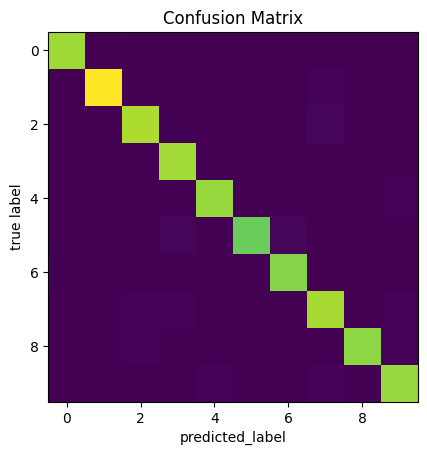

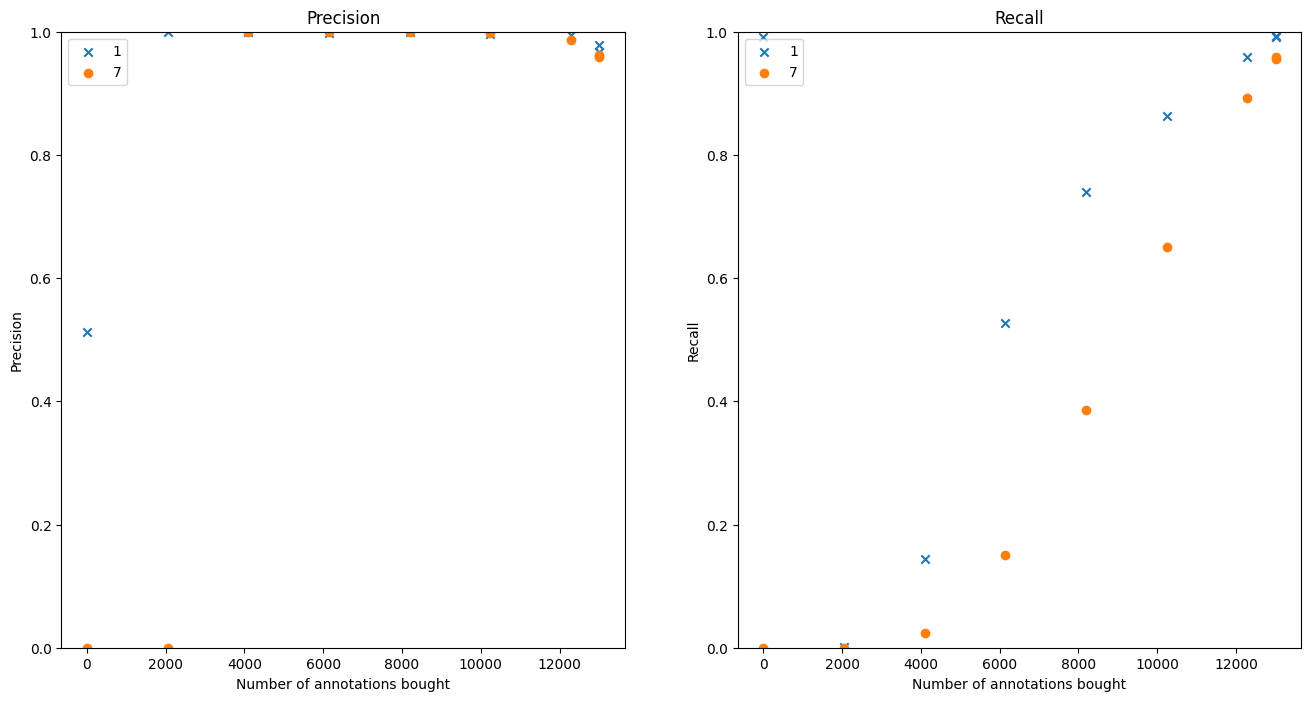

In [13]:
score_tracker.train_and_score_model(train_dataset, plot_confusion_matrix=True)
score_tracker.plot_scores()